In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#修改尺寸
def img_resize(img, hight):
    (h, w) = img.shape[0], img.shape[1]
    r = h / hight
    width = w / r
    img = cv2.resize(img, (int(width), int(hight)))    
    return img

In [3]:
#读入总模板
img = cv2.imread('images/ocr_a_reference.png')
ref = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ref,thresh= cv2.threshold(ref, 127, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

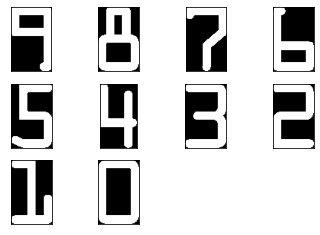

In [4]:
for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i])
    plt.subplot(3, 4, i + 1)
    plt.imshow(thresh[y:y + h, x:x + w], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])

plt.show()

In [5]:
#保存模板
if not os.path.exists('data'):
    os.mkdir('data')

for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i])
    cv2.imwrite(os.path.join('data', str(9-i)+'.jpg'), thresh[y:y+h, x:x+w])

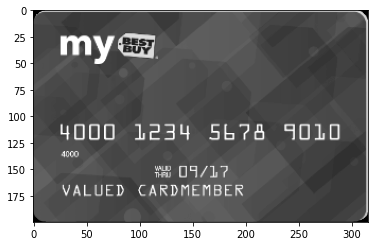

In [6]:
#灰度化
img = cv2.imread('images/credit_card_01.png')
img = img_resize(img, 200)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap=plt.cm.gray)

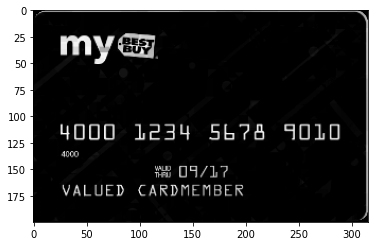

In [7]:
#礼貌操作
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 5))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
tophat = cv2.morphologyEx(gray,cv2.MORPH_TOPHAT,rectKernel)
plt.imshow(tophat, cmap=plt.cm.gray)

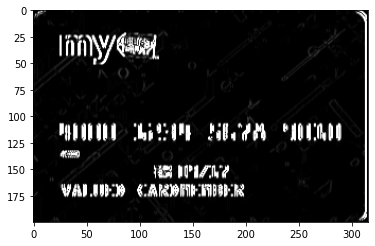

In [8]:
#sobel边缘检测
sobel = cv2.Sobel(tophat, cv2.CV_64F,dx=1, dy=0, ksize=3)
sobel = cv2.convertScaleAbs(sobel)
minval, maxval = np.min(sobel), np.max(sobel)
sobel = (255 * ((sobel - minval) / (maxval - minval)))
sobex = sobel.astype('uint8')
plt.imshow(sobex, cmap=plt.cm.gray)

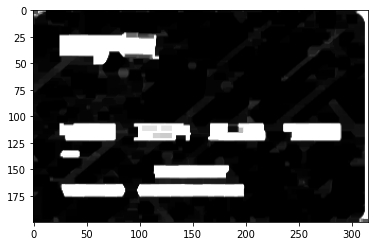

In [9]:
#膨胀腐蚀
dilate = cv2.dilate(sobel, rectKernel, 10)
erosion = cv2.erode(dilate, rectKernel, 10)
plt.imshow(erosion, cmap=plt.cm.gray)

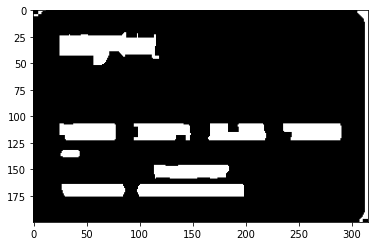

In [10]:
#二值化
erosion = cv2.convertScaleAbs(erosion)
ret, thresh = cv2.threshold(erosion, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
plt.imshow(thresh, cmap=plt.cm.gray)

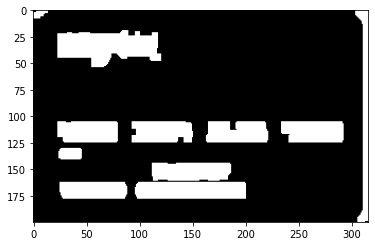

In [11]:
#膨胀腐蚀
dilate = cv2.dilate(thresh, sqKernel, 10)
erosion = cv2.erode(dilate, sqKernel, 10)
plt.imshow(dilate, cmap=plt.cm.gray)

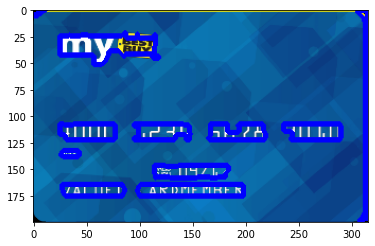

In [12]:
#画轮廓
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cur_img = img.copy()
cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
cv2.drawContours(cur_img,contours,-1,(0,0,255),3)
plt.imshow(cur_img)

4


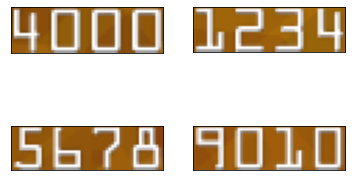

In [13]:
#过滤轮廓
locs = []
for(i,c) in enumerate(contours):
    (x,y,w,h) = cv2.boundingRect(c)
    ar = w/float(h)
    if ar>2.5 and ar<4.0:
        if(w>40 and w<60) and (h>10 and h<20):
            locs.append((x,y,w,h))
print(len(locs))

for i in range(len(locs)):
    x,y,w,h = locs[3-i]
    contour = img[y:y+h, x:x+w,:]
    plt.subplot(2, 2, i+1)
    plt.imshow(contour)
    plt.xticks([])
    plt.yticks([])
        
plt.show()

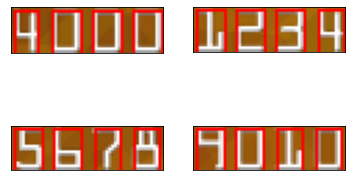

In [14]:
#进行最后的处理
results = []
for i in range(len(locs)):
    x,y,w,h = locs[3-i]
    img_new = img[y:y+h, x:x+w,:]
    gray = cv2.cvtColor(img_new, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    res = img_new.copy()
    for j in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[3-j])
        res = cv2.rectangle(res, (x, y), (x+w, y+h), (255, 0, 0), 1)
        results.append(thresh[y:y+h, x:x+w])
    
    plt.subplot(2, 2, i+1)
    plt.imshow(res, cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
        
plt.show()

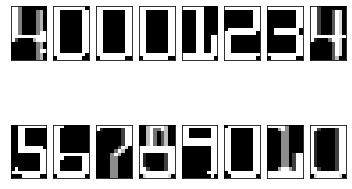

In [15]:
#可以看一下results
for i in range(16):
    results[i] = cv2.resize(results[i], (10, 15))
    plt.subplot(2, 8, i+1)
    plt.imshow(results[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
        
plt.show()

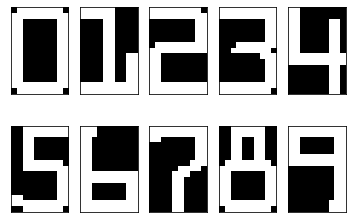

In [16]:
#引入模板
digits = {}
for i in range(10):
    digits[i] = cv2.resize(cv2.imread('data/{}.jpg'.format(i)), (10, 15))
    digits[i] = cv2.cvtColor(digits[i], cv2.COLOR_BGR2GRAY)
    ref, digits[i] = cv2.threshold(digits[i], 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(digits[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
        
plt.show()

4000123456789010


<function matplotlib.pyplot.show(close=None, block=None)>

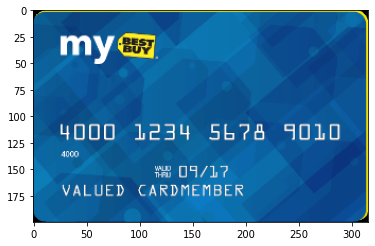

In [17]:
#模板匹配得出结果
res = ''
for i in results:
    scores = []
    for j in range(10):
        result = cv2.matchTemplate(i, digits[j], cv2.TM_CCOEFF)  # result为一个输出矩阵
        (_, score, _, _) = cv2.minMaxLoc(result)  # 这个方法会返回最小值，最大值，最小值位置和最大值位置
        scores.append(score)
    res = res + str(np.argmax(scores))
print(res)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show